In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker
mpl.style.use("plotting.mplstyle")
import pandas as pd
import sys
sys.path.append('./../../pdet/')
from pdet.emulator import *
sys.path.append("./../code/")
from training_routines import *
from draw_new_injections import draw_new_injections
import tqdm
from figure_utilities import *

np.random.seed(230529)

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [2]:
# Load network
ann = pdet_O3()
jitted_ann = jax.jit(ann)

In [3]:
# Draw CDFs to be used in dynamic injection generation
injectionData = draw_vals(100000)

# Prep arrays to hold estimated efficiencies and sample sizes
n = 100
inj_effs = np.zeros(n)
nn_effs = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn = np.zeros(n)

# Choose population hyperparameters, and prepare
# array of log-widths for cos tilt distribution
alphas = -3.
kappas = 3.
mu_m1 = 35.
sig_m1 = 5.
log_f_peaks = -3.
mMaxs = 80.
mMins = 10.
log_dmMaxs = 1.
log_dmMins = 0.
bqs = 2.
mu_chis = 0.
logsig_chis = np.linspace(-4,0.5,n)
f_iso = 0.5
mu_costs = 1.
sig_costs = 0.5

# Loop across parameters
for i in tqdm.tqdm(range(n)):
    
    # Reweight pipeline injections.
    # First argument is estimated detection efficiency,
    # second is number of effective samples in Monte Carlo average
    inj_effs[i], neff_inj[i] = get_inj_efficiency(
        alphas,
        mu_m1,
        sig_m1,
        log_f_peaks,
        mMaxs,
        mMins,
        log_dmMaxs,
        log_dmMins,
        bqs,
        mu_chis,
        logsig_chis[i],
        f_iso,
        mu_costs,
        sig_costs,
        kappas)
    
    # Use neural net to directly average Pdet over proposed population
    # (subject to reweighting in redshift, as described in paper text).
    # First argument is estimated detection efficiency. Second is number
    # of effective samples in Monte Carlo integral over Pdet.
    # Third (ignored) is number of effective draws from target distribution,
    # after reweighting in redshift
    nn_effs[i], neff_nn[i], _ = get_nn_efficiency(
        jitted_ann,
        injectionData,
        alphas,
        mu_m1,
        sig_m1,
        log_f_peaks,
        mMaxs,
        mMins,
        log_dmMaxs,
        log_dmMins,
        bqs,
        mu_chis,
        logsig_chis[i],
        f_iso,
        mu_costs,
        sig_costs,
        kappas,
        hybrid=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


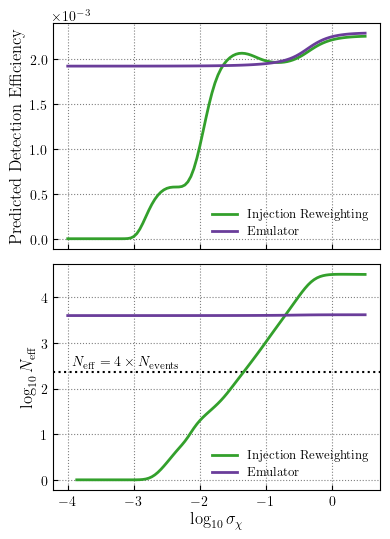

In [4]:
# Plot
fig = plt.figure(figsize=(4,5.5))

ax = fig.add_subplot(211)
sorting = np.argsort(logsig_chis)
ax.plot(logsig_chis[sorting],(inj_effs)[sorting],color=cnsbh,lw=2,label='Injection Reweighting')
ax.plot(logsig_chis[sorting],(nn_effs)[sorting],color=cmisc,lw=2,label='Emulator')
ax.set_ylabel(r"Predicted Detection Efficiency")
ax.legend(loc='lower right',fontsize=9)

formatter = matplotlib.ticker.ScalarFormatter(useOffset=False, useMathText=True)
formatter.set_powerlimits((-2, 2))
ax.yaxis.set_major_formatter(formatter)

ax.set_xticklabels([])

ax = fig.add_subplot(212)
ax.plot(logsig_chis[sorting],np.log10(neff_inj)[sorting],color=cnsbh,lw=2,label='Injection Reweighting')
ax.plot(logsig_chis[sorting],np.log10(neff_nn)[sorting],color=cmisc,lw=2,label='Emulator')
ax.set_xlabel(r"$\log_{10}\sigma_\chi$")
ax.set_ylabel(r"$\log_{10} N_\mathrm{eff}$")
ax.legend(loc='lower right',fontsize=9)

ax.axhline(y=np.log10(4*59),color='black',ls=':',zorder=0)
ax.text(0.06,0.55,r'$N_\mathrm{eff} = 4\times N_\mathrm{events}$',transform=ax.transAxes,fontsize=10)

plt.tight_layout()
plt.savefig('figure_07.pdf',bbox_inches='tight')
plt.show()

In [7]:
test = draw_vals(100000)

n = 50
inj_effs = np.zeros(n)
nn_effs = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn = np.zeros(n)

alphas = -3.
kappas = np.linspace(-1,4,n)
mu_m1 = 35.
sig_m1 = 5.
log_f_peaks = -3.
mMaxs = 80.
mMins = 10.
log_dmMaxs = 1.
log_dmMins = 0.
bqs = 2.
mu_chis = 0.
logsig_chis = -1
f_iso = 0.5
mu_costs = 1
sig_costs = 0.5

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
        alphas,
        mu_m1,
        sig_m1,
        log_f_peaks,
        mMaxs,
        mMins,
        log_dmMaxs,
        log_dmMins,
        bqs,
        mu_chis,
        logsig_chis,
        f_iso,
        mu_costs,
        sig_costs,
        kappas[i])
    
    nn_effs[i],neff_nn[i],_ = get_nn_efficiency(
        jitted_ann,
        injectionData,
        alphas,
        mu_m1,
        sig_m1,
        log_f_peaks,
        mMaxs,
        mMins,
        log_dmMaxs,
        log_dmMins,
        bqs,
        mu_chis,
        logsig_chis,
        f_iso,
        mu_costs,
        sig_costs,
        kappas[i],
        hybrid=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


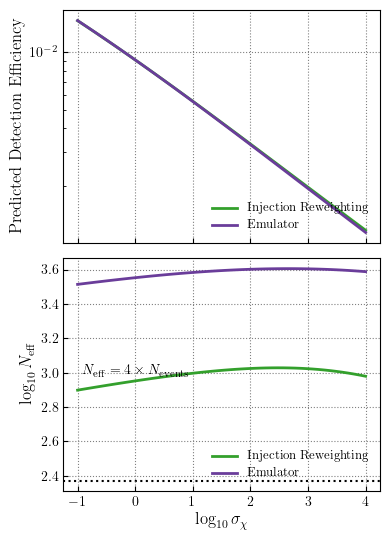

In [10]:
fig = plt.figure(figsize=(4,5.5))

ax = fig.add_subplot(211)
sorting = np.argsort(kappas)
ax.plot(kappas[sorting],(inj_effs)[sorting],color=cnsbh,lw=2,label='Injection Reweighting')
ax.plot(kappas[sorting],(nn_effs)[sorting],color=cmisc,lw=2,label='Emulator')
ax.set_ylabel(r"Predicted Detection Efficiency")
ax.legend(loc='lower right',fontsize=9)

formatter = matplotlib.ticker.ScalarFormatter(useOffset=False, useMathText=True)
formatter.set_powerlimits((-2, 2))
ax.yaxis.set_major_formatter(formatter)

ax.set_xticklabels([])
ax.set_yscale('log')

ax = fig.add_subplot(212)
ax.plot(kappas[sorting],np.log10(neff_inj)[sorting],color=cnsbh,lw=2,label='Injection Reweighting')
ax.plot(kappas[sorting],np.log10(neff_nn)[sorting],color=cmisc,lw=2,label='Emulator')
ax.set_xlabel(r"$\log_{10}\sigma_\chi$")
ax.set_ylabel(r"$\log_{10} N_\mathrm{eff}$")
ax.legend(loc='lower right',fontsize=9)

ax.axhline(y=np.log10(4*59),color='black',ls=':',zorder=0)
ax.text(0.06,0.5,r'$N_\mathrm{eff} = 4\times N_\mathrm{events}$',transform=ax.transAxes,fontsize=10)

plt.tight_layout()
#plt.savefig('figure_07.pdf',bbox_inches='tight')
plt.show()